# Time Series Analysis: MARA
In this notebook, we will perform a time series analysis on the historical stock price for MARA denoting Marathon Digital Holdings, Inc. The company operates as a digital asset technology company that mines cryptocurrencies with a focus on the blockchain ecosystem and the generation of digital assets in United States. As of December 31, 2021, it had approximately 8,115 bitcoins, which included the 4,794 bitcoins held in the investment fund.

## Table of Contents
1. Environment set-up
2. Initial Diagonistics
    * Basic Visualization
3. Decomposition
    * Detrend
    * Deseasonalize
    * Test for seasonality of a Time Series
        * Autocorrelation
        * Dick-Fuller test
        * Lag Plots
4. Smoothening a Time Series
    * Exponential smoothing, Holt-Winters model
    
5. Forecasting Models
    * SARIMA
    * Feature Engineering
    * Linear models
    * Ensemble methods

# 1. Environment set-up

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
sns.set_theme()

from scipy import signal
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm


from sklearn.model_selection import TimeSeriesSplit, cross_validate

import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import sklearn.ensemble as emb

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from dateutil.parser import parse

# Model Performance metrics
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

# 2. Initial Diagonistics

In [28]:
df = pd.read_csv('MARA.csv')
df['Date'] = df['Date'].apply(lambda x: x.replace(' 00:00:00-04:00', ' 00:00:00'))
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.index = df['Date']
df.drop(['Date','Open','High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],  axis=1, inplace=True)
# Close price is the actual final daily price -- renaming the column accordingly
df.rename({'Close':'Price'}, axis='columns', inplace=True)
df.head()

Price
Date                            
2017-10-16 00:00:00+00:00   6.56
2017-10-17 00:00:00+00:00   6.40
2017-10-18 00:00:00+00:00   6.08
2017-10-19 00:00:00+00:00   5.92
2017-10-20 00:00:00+00:00   6.08

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-10-16 00:00:00+00:00 to 2022-10-14 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


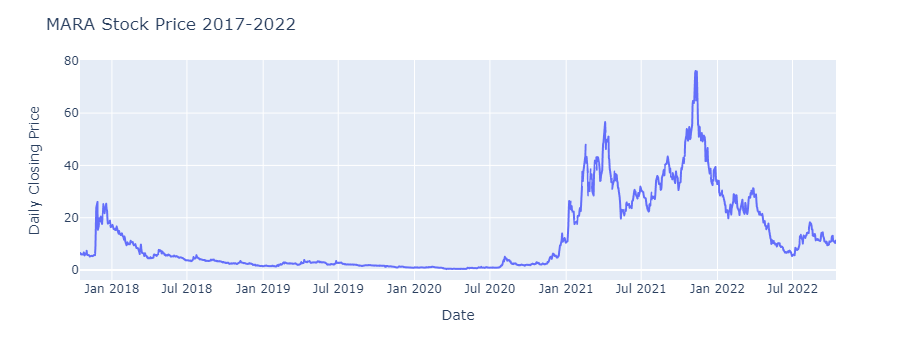

In [4]:
def plot_all(data=df, tck='MARA'):
    ''' Basic visual of a line plot of daily stock price overtime
    '''
    fig = px.line(df, x=df.index, y=df.Price)
    fig.update_layout(title=tck+' Stock Price 2017-2022',
                       xaxis_title='Date',
                       yaxis_title='Daily Closing Price')
    fig.show()
plot_all()

# 3. Decomposition
For a continuous time series $F_{t}$ over a discrete-time period $t$, we can proceed in breaking down the series as a function following an **additive** method: $F_{t}$ = $d_t$ + $s_t$ + $r_t$ or a **multiplicative** one: $F_{t}$ = $d_t$ * $s_t$ * $r_t$, where $d_{t}$ is a trend component, $s_{t}$ is a seasonal (periodic) component, and $r_{t}$ is a residual component. 

In essence, the decomposition of a time series is the process by which we isolate all those single elements: trend, seasonality, and residual. This technique serves to disentangle the time series for a more comprehensive analysis, most importantly facilitate the forecasting process.

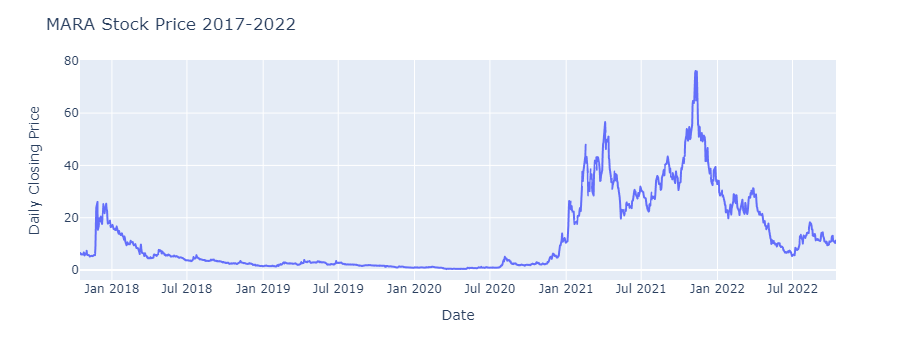

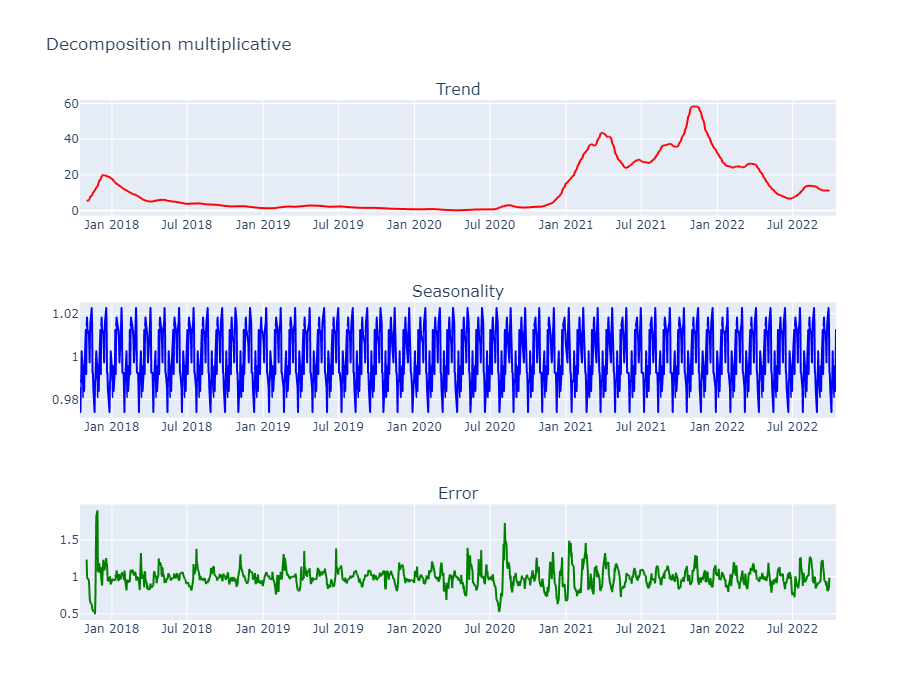

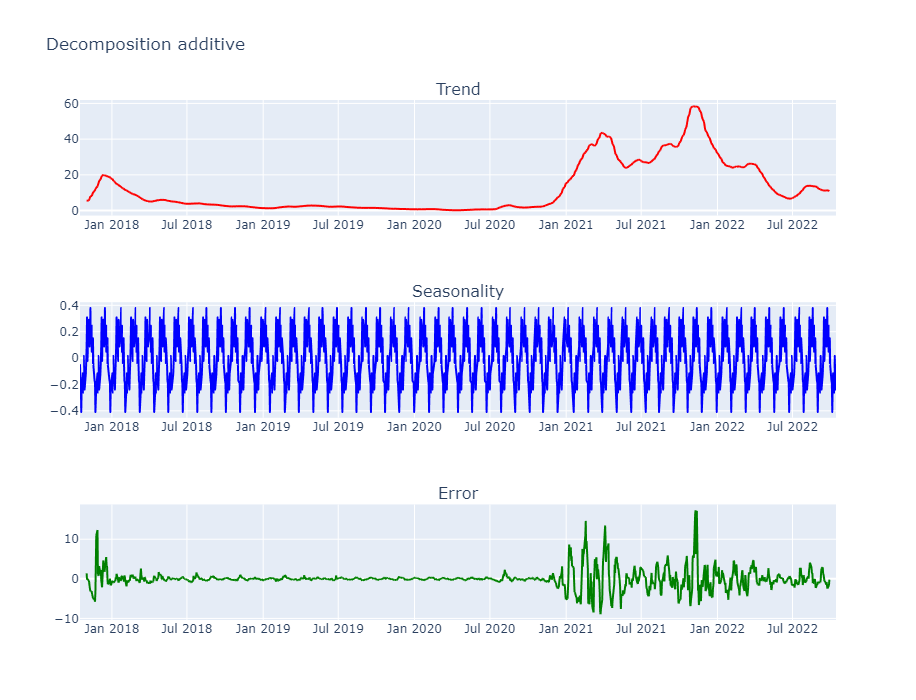

In [5]:
def decompose_view(var=df['Price'], prd=24):
    
    ''' Determine the suitable combination of base level, trend, seasonal index and the residual term.
    '''
    plot_all()
    for mod in ['multiplicative','additive']:
        decomp_func = seasonal_decompose(var, model = mod, period=prd)
        figures = [
            px.line(decomp_func.trend, color_discrete_map={'trend':'red'}), 
            px.line(decomp_func.seasonal, color_discrete_map={'seasonal':'blue'}),
            px.line(decomp_func.resid, color_discrete_map={'resid':'green'})
        ]
        fig = make_subplots(rows=len(figures), cols=1,
                            subplot_titles=('Trend', 'Seasonality','Error'),) 

        for i, figure in enumerate(figures):
            for trace in range(len(figure["data"])):
                fig.append_trace(figure["data"][trace], row=i+1, col=1)

        fig.update_layout(title="Decomposition "+mod,
                          height=700, showlegend=False)
        fig.show()

decompose_view()

**Takeaway**: We note less residuals found using the additive decomposition compared to the multiplicative.

[Reference](https://www.alpharithms.com/autocorrelation-time-series-python-432909/)

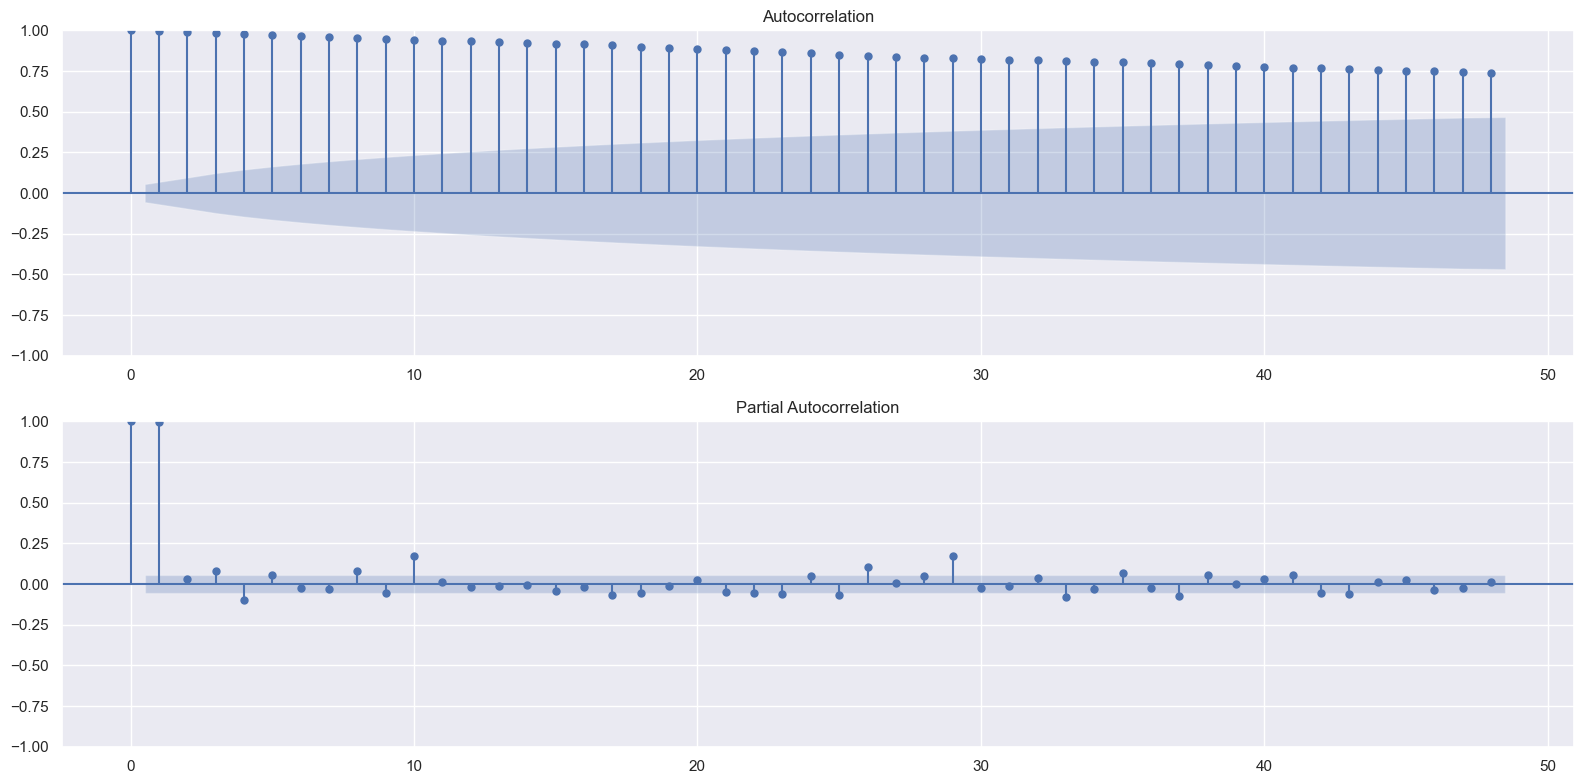

In [6]:
# Courtesy of : https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook
def acf_pacf(var=df['Price'], n=48):
    fig = plt.figure(figsize=(16,8))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))

    smt.graphics.plot_acf(var, lags=n, ax=acf_ax)
    smt.graphics.plot_pacf(var, lags=n, ax=pacf_ax)
    plt.tight_layout()
    
    return
acf_pacf()

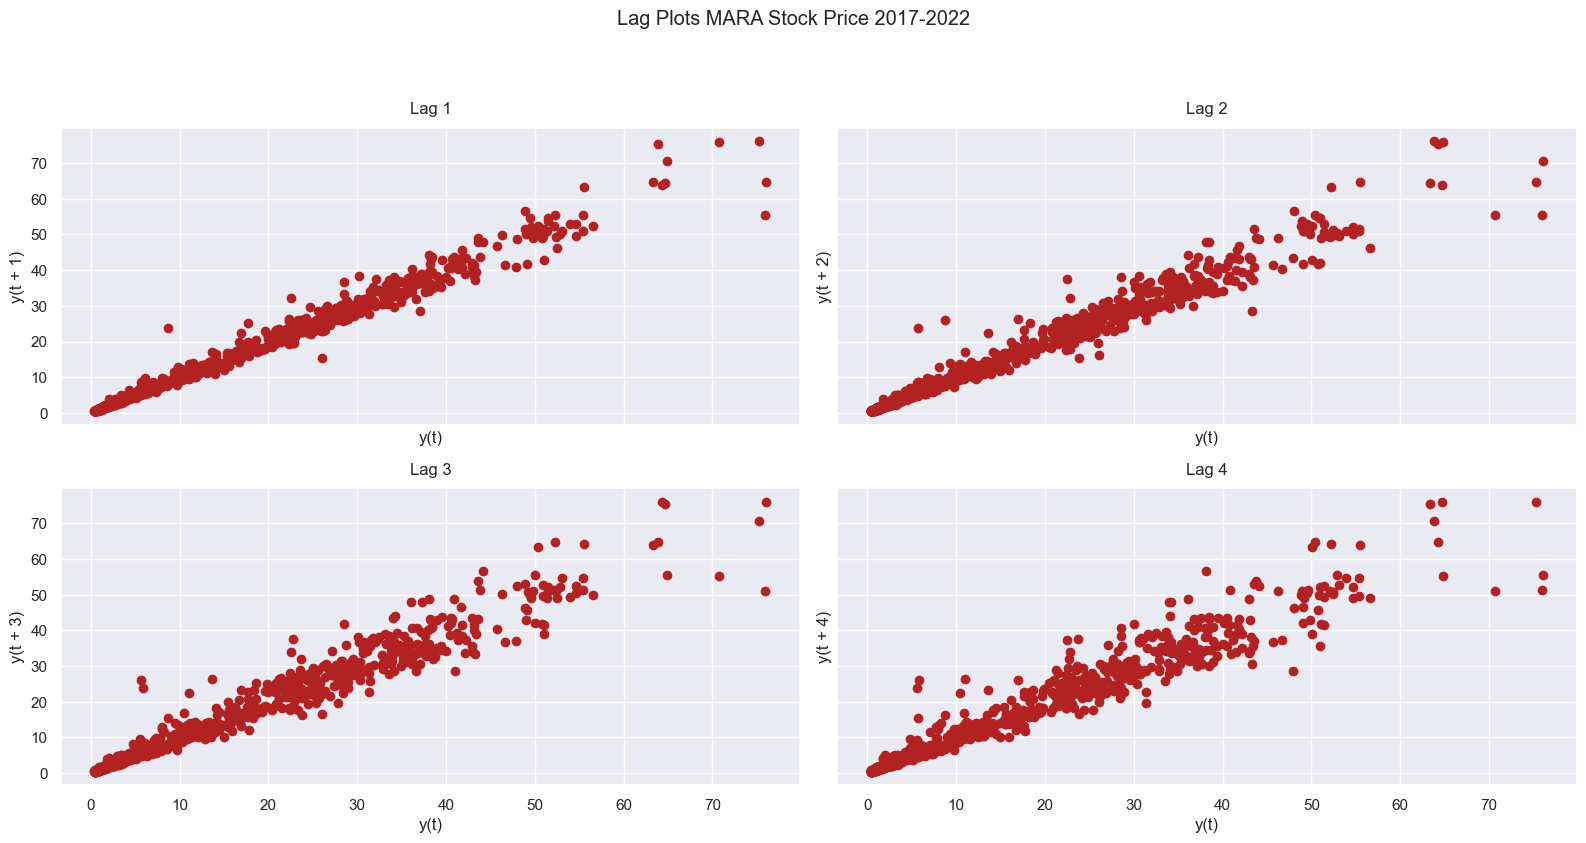

In [7]:
def lag_plots(var=df['Price'], tck='MARA', n=4):
    from pandas.plotting import lag_plot
    plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

    # Plot
    fig, axes = plt.subplots(2,2, figsize=(16,8), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:n]):
        lag_plot(var, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle('Lag Plots {} Stock Price 2017-2022'.format(tck), y=1.05)    
    fig.tight_layout(pad=1.0)
    plt.show()
    
lag_plots()

# Stationary
[Reference](https://machinelearningmastery.com/time-series-data-stationary-python/)

The **Augmented Dickey-Fuller** (ADF) test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

In [8]:
def DCF(var=df['Price']):
    result = adfuller(var)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
DCF()

ADF Statistic: -1.715332
p-value: 0.423231
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


**Takeaway:** In this instance, we fail to reject the null hypothesis, thus indicating that our time series for the MARA stock price is non-statinary. If we aim to predict future prices, we ought to make it stationary. There are reasons why we want to convert a non-stationary series into a stationary one. These are given below:

* More reliabale forecasting
* An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors.
* Mitigating the issue of multi-colinearity for more robust linear regression models

We can apply some sort of transformation to make the time-series stationary. These transformation may include:
* Differencing the Series (once or more)
* Take the log of the series
* Take the nth root of the series
* Combination of the above

In our case scenario, we will use the **differencing** method

ADF Statistic: -13.716202
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


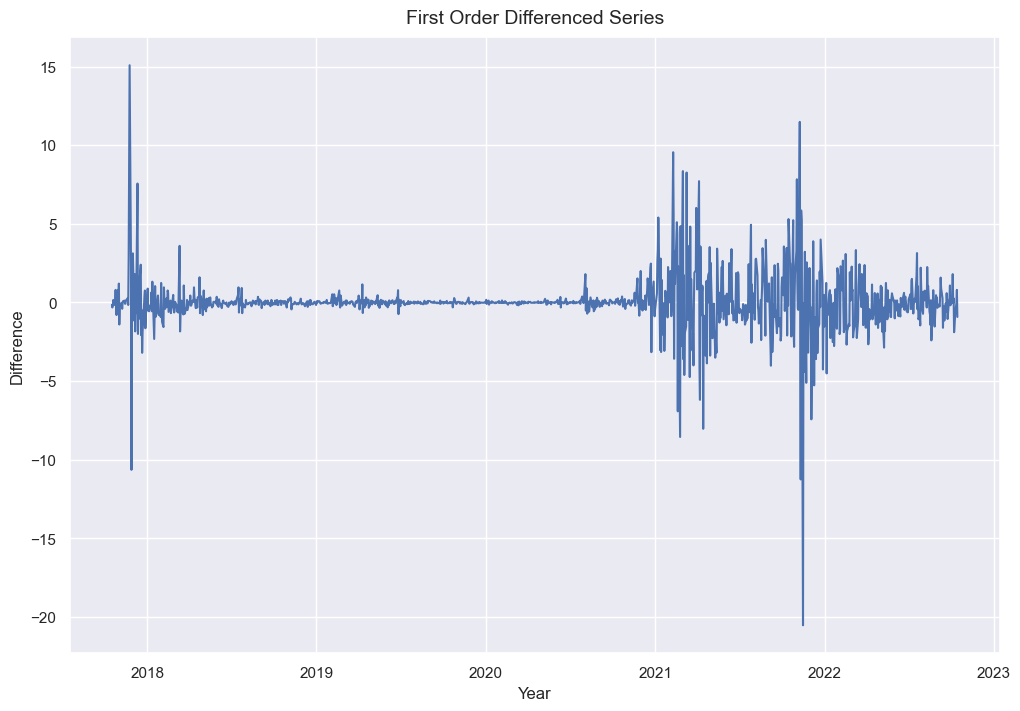

In [9]:
# Change for (t)th day is Close for (t)th day minus Close for (t-1)th day.
def stationarize_diff(var=df['Price']):
    diff_1 = var.diff()
    # result = adfuller(df.Difference.dropna())
    DCF(var=diff_1.dropna())
    # Plot the Change
    plt.figure(figsize=(12,8))
    plt.plot(diff_1)
    plt.title('First Order Differenced Series', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.show()
    
stationarize_diff()

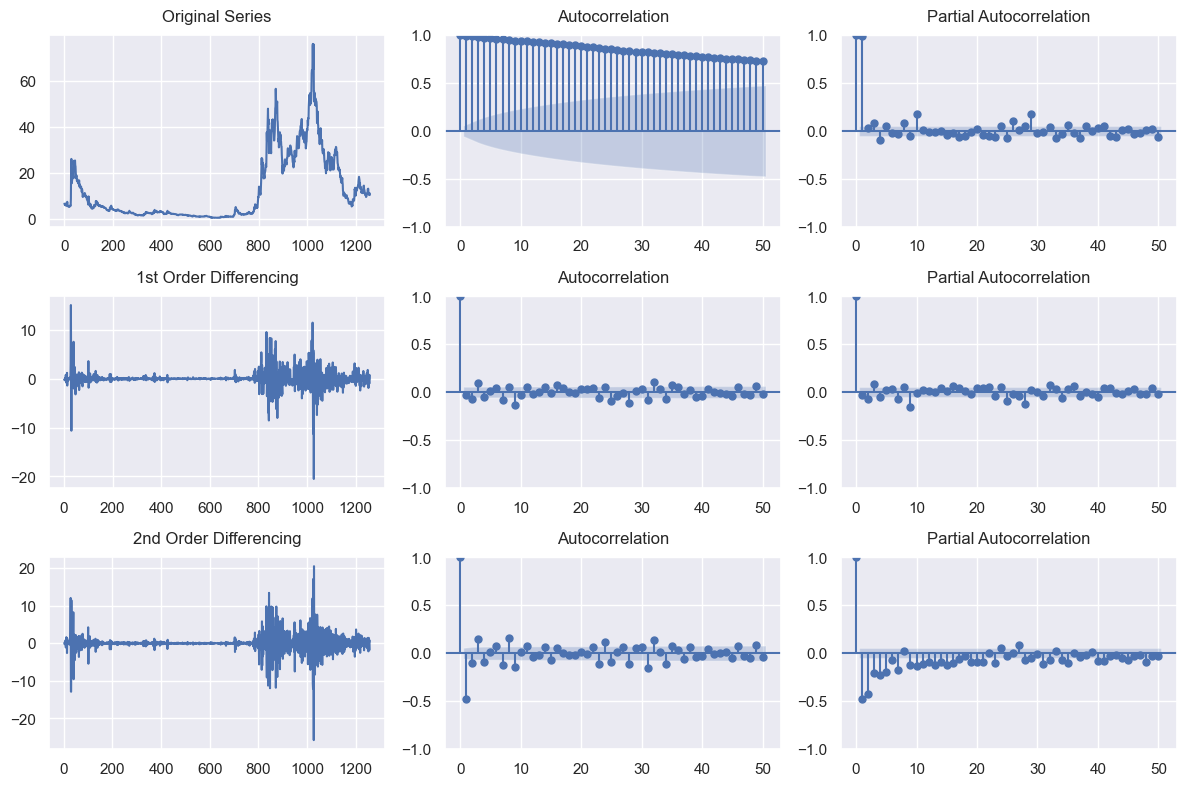

In [10]:
# Using this method to find the best 'd'
def stationarize_diff(var=df['Price'].values):
    plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':100})

    # Original Series
    fig, axes = plt.subplots(3,3, sharex=False)
    axes[0, 0].plot(var); axes[0, 0].set_title('Original Series')

    plot_acf(var, ax=axes[0, 1], lags=50)
    plot_pacf(var, ax=axes[0, 2], lags=50)

    # 1st Differencing
    var = pd.Series(var)
    axes[1, 0].plot(var.diff()); axes[1, 0].set_title('1st Order Differencing')
    plot_acf(var.diff().dropna(), ax=axes[1, 1], lags=50)
    plot_pacf(var.diff().dropna(), ax=axes[1, 2], lags=50)

    # 2nd Differencing
    axes[2, 0].plot(var.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(var.diff().diff().dropna(), ax=axes[2, 1], lags=50)
    plot_pacf(var.diff().diff().dropna(), ax=axes[2, 2], lags=50)

    fig.tight_layout(pad=1.0)
    plt.show()
stationarize_diff()

# Forecasting 
[Reference](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
## ARIMA-family Crash-Course
We will explain this model by building up letter by letter.  SARIMA(p,d,q)(P,D,Q,s) , Seasonal Autoregression Moving Average model:

* AR(p)  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p . To determine the initial  p , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.
* MA(q)  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q . The initial value can be found on the ACF plot with the same logic as before.
Let's combine our first 4 letters:

* AR(p)+MA(q)=ARMA(p,q) 
What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

* I(d)  - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the  ARIMA  model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

* S(s)  - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters:  (P,D,Q) 
* P  - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial  P  should be 2.

* Q  - similar logic using the ACF plot instead.

* D  - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

**Notes:** 
* The ACF tells how many MA terms (q) are required to remove any autocorrelation in the stationarized series.
* You can find out the required number of AR terms (p) by inspecting the Partial Autocorrelation (PACF) plot.

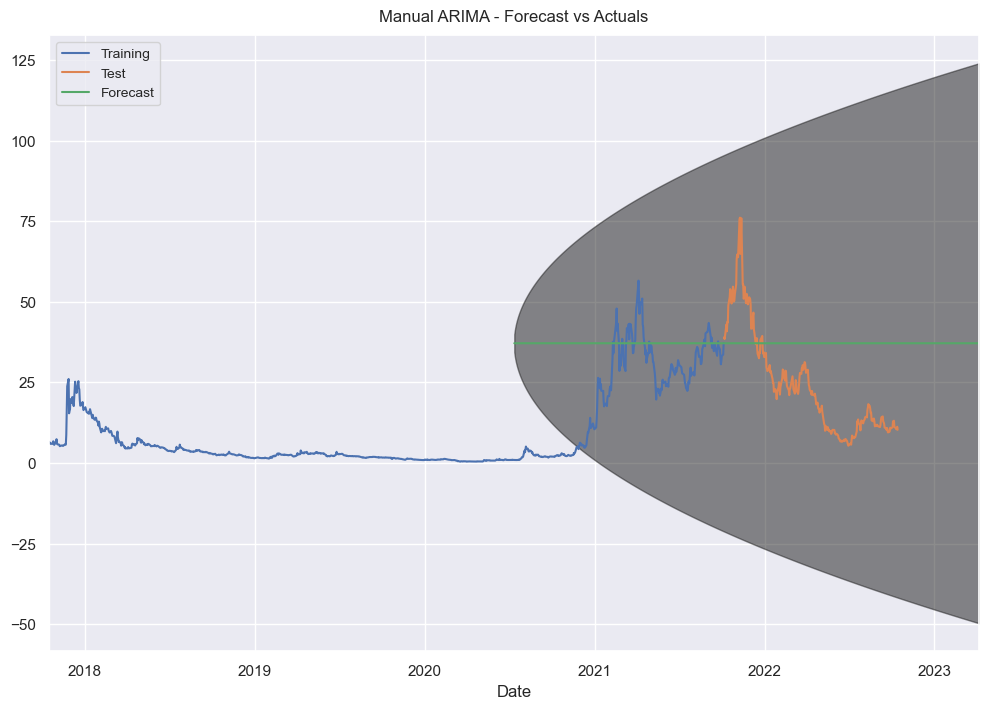

In [11]:
# Create Training and Test
def sample_split(data=df, prd='d', cut_off=1000):
    data = df.copy()
    data.index = data.index.to_period('d')
    global train, test
    train = data.Price[:cut_off]
    test = data.Price[cut_off:]
    
def simple_arima(var, p_d_q=(1,1,1), n_steps=1000):
    # Manual ARIMA model
    model = ARIMA(var, order=p_d_q)
    model_fit = model.fit()
    fc = model_fit.get_forecast(steps=1000).summary_frame()

    plt.figure(figsize=(12,8), dpi=100)
    train.plot(label='Training')
    test.plot(label='Test')
    fc['mean'].plot(label='Forecast')
    plt.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='k', alpha=0.5)
    plt.title('Manual ARIMA - Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=10)
    plt.show()
    
    
sample_split(data=df)
simple_arima(var=train)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -1753.638
Date:                Thu, 20 Oct 2022   AIC                           3523.276
Time:                        10:18:51   BIC                           3562.530
Sample:                             0   HQIC                          3538.196
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0447      0.050     -0.889      0.374      -0.143       0.054
ar.L2         -0.1208      0.056     -2.172      0.030      -0.230      -0.012
ar.L3          0.7332      0.059     12.354      0.0

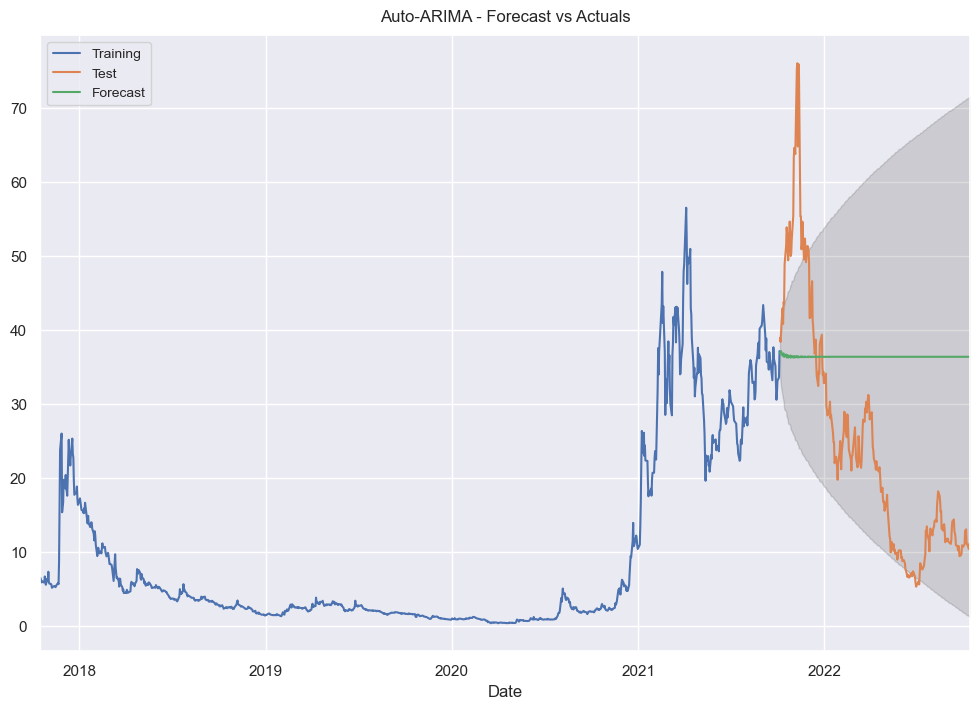

In [12]:
# Actual vs Fitted
def auto_arima_model():
    auto_arima = pm.auto_arima(train, stepwise=True, seasonal=True)
    print(auto_arima.summary())

    # Make as pandas series
    fc, conf = auto_arima.predict(n_periods=test.shape[0], return_conf_int=True)
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    plt.figure(figsize=(12,8), dpi=100)
    train.plot(label='Training')
    test.plot(label='Test')
    fc_series.plot(label='Forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Auto-ARIMA - Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=10)
    plt.show()
    
auto_arima_model()

# Machine Learning

In [29]:
# Adding the lag of the target variable from 6 steps back up to 24
def feature_engineering(df):
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Week'] = df.index.week
    df['Day'] = df.index.day
    df["Weekday"] = df.index.weekday

    for i in range(6, 25):
        df["lag_{}".format(i)] = df.Price.shift(i)

    return df

df = feature_engineering(df)
df.tail()

Price  Year  Quarter  Month  Week  Day  Weekday  \
Date                                                                         
2022-10-10 00:00:00+00:00  10.76  2022        4     10    41   10        0   
2022-10-11 00:00:00+00:00  10.46  2022        4     10    41   11        1   
2022-10-12 00:00:00+00:00  10.42  2022        4     10    41   12        2   
2022-10-13 00:00:00+00:00  11.22  2022        4     10    41   13        3   
2022-10-14 00:00:00+00:00  10.30  2022        4     10    41   14        4   

                           lag_6  lag_7  lag_8  ...  lag_15  lag_16  lag_17  \
Date                                            ...                           
2022-10-10 00:00:00+00:00  10.71  10.77  10.95  ...   10.87   10.92   12.07   
2022-10-11 00:00:00+00:00  11.08  10.71  10.77  ...   10.26   10.87   10.92   
2022-10-12 00:00:00+00:00  12.88  11.08  10.71  ...   10.85   10.26   10.87   
2022-10-13 00:00:00+00:00  12.84  12.88  11.08  ...   10.52   10.85   10.26   
2022-10-14 00:00:00+00:00  13.10  12.84  12.88  ...    9.47   10.52   10.85   

                           lag_18  lag_19  lag_20  lag_21  lag_22  lag_23  \
Date                                                                        
2022-10-10 00:00:00+00:00   12.60   12.82   14.43   14.16   13.26   11.68   
2022-10-11 00:00:00+00:00   12.07   12.60   12.82   14.43   14.16   13.26   
2022-10-12 00:00:00+00:00   10.92   12.07   12.60   12.82   14.43   14.16   
2022-10-13 00:00:00+00:00   10.87   10.92   12.07   12.60   12.82   14.43   
2022-10-14 00:00:00+00:00   10.26   10.87   10.92   12.07   12.60   12.82   

                           lag_24  
Date                               
2022-10-10 00:00:00+00:00   11.12  
2022-10-11 00:00:00+00:00   11.68  
2022-10-12 00:00:00+00:00   13.26  
2022-10-13 00:00:00+00:00   14.16  
2022-10-14 00:00:00+00:00   14.43  

[5 rows x 26 columns]

In [30]:
def train_test_split(var='Price', test_size=0.2):
    y = df.dropna()[var]
    X = df.dropna().drop([var], axis=1)
    # get the index after which test set starts
    idx = int(len(X)*(1-test_size))
    
    global X_train, y_train, X_test, y_test
    X_train, y_train = X.iloc[:idx], y.iloc[:idx]
    X_test, y_test = X.iloc[idx:], y.iloc[idx:]
    

train_test_split()

In [32]:
# machine learning in two lines
def machine_learning_forecasting(models=[lm.LinearRegression(), lm.ElasticNet(), 
                                        lm.Lasso(), lm.Ridge(),
                                        KNeighborsRegressor()],
                                n_folds=10):

    
    models_perf = {'Models': []}
    metrics = ['MAE_', 'MAPE_', 'MSE_', 'RMSE_']
    for met in metrics:
        models_perf[met+'mean'] = list()
        models_perf[met+'std'] = list()

    for model in models:
        # m = str(model)
        # models_perf['Models'].append(m[:m.find("(")])
        models_perf['Models'].append(model)
        tscv = TimeSeriesSplit(n_splits=n_folds)
        cv = cross_validate(model, X_train, y_train, cv=tscv, 
                            scoring=("neg_mean_absolute_error",
                                      'neg_mean_absolute_percentage_error',
                                      'neg_mean_squared_error'))
        
        scores = [abs(cv['test_neg_mean_absolute_error']),
                  abs(cv['test_neg_mean_absolute_percentage_error']),
                  abs(cv['test_neg_mean_squared_error']),
                  np.sqrt(abs(cv['test_neg_mean_squared_error']))
                 ]

        for idx, score in enumerate(scores):
            met = metrics[idx]
            models_perf[met+'mean'].append(np.mean(score))
            models_perf[met+'std'].append(np.std(score))
    model_df = pd.DataFrame(models_perf).sort_values(by='MAE_mean', ascending=True)
    return model_df

machine_learning_forecasting()

Models  MAE_mean   MAE_std  MAPE_mean  MAPE_std    MSE_mean  \
2                Lasso()  2.261673  1.974843   0.448312  0.368648   14.723250   
1           ElasticNet()  2.304828  2.006186   0.451802  0.384892   14.952122   
3                Ridge()  2.755319  2.366526   0.785458  0.886944   19.164239   
0     LinearRegression()  3.475778  2.920223   1.104841  1.450523  125.131358   
4  KNeighborsRegressor()  4.540339  4.970192   1.039774  0.889977   62.720496   

      MSE_std  RMSE_mean  RMSE_std  
2   20.919708   2.855142  2.563477  
1   21.202174   2.888187  2.571089  
3   25.597732   3.335500  2.835257  
0  319.445031   6.379549  9.188728  
4  116.054985   5.657594  5.541853

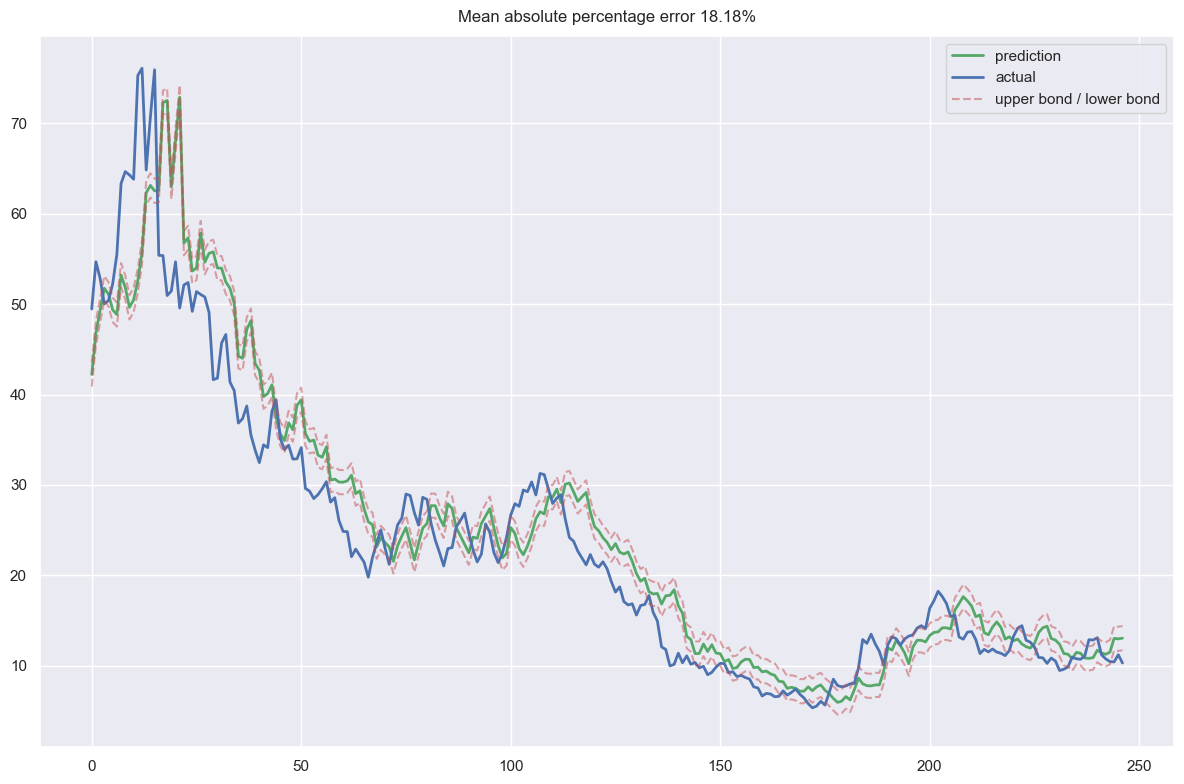

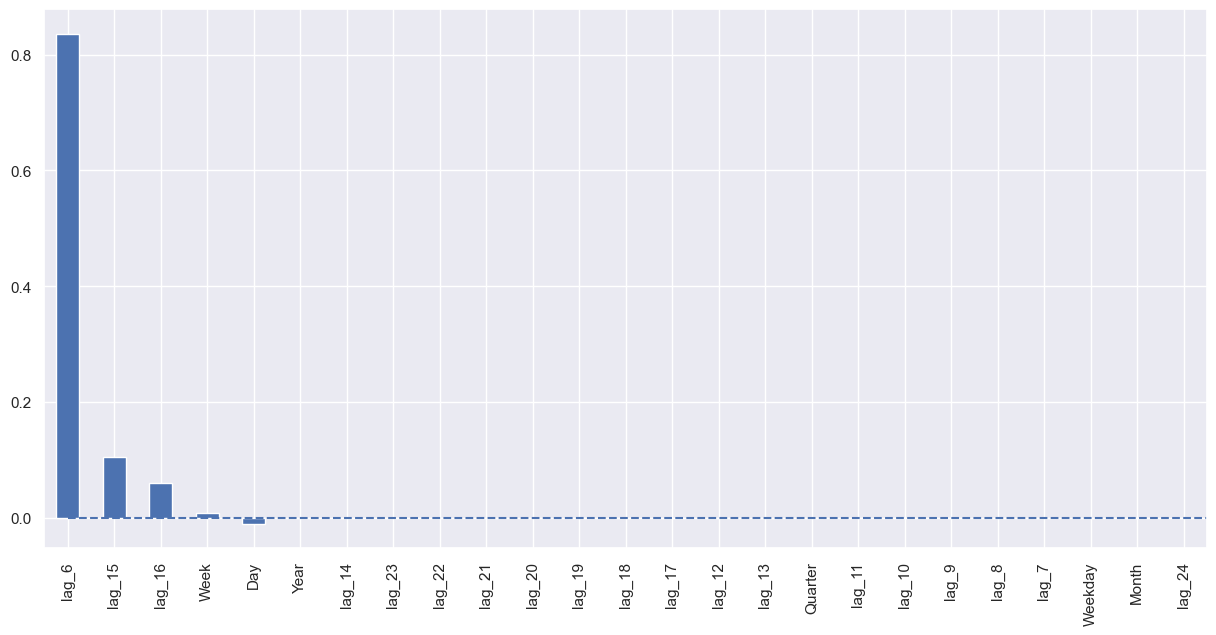

In [33]:
def best_model_visual(model=lm.Lasso()):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = mean_absolute_percentage_error(y_test, pred)
    tscv = TimeSeriesSplit(n_splits=5)
    cv = cross_validate(model, X_train, y_train, cv=tscv, 
                        scoring="neg_mean_absolute_percentage_error")
    metric = abs(cv['test_score'])
    mape, std = np.mean(metric), np.std(metric)

    scale = 1.96
    lower = pred - (mape + scale * std)
    upper = pred + (mape + scale * std)

    plt.figure(figsize=(12,8))
    plt.plot(pred, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
    plt.plot(upper, "r--", alpha=0.5)
    plt.title("Mean absolute percentage error {:.2%}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    
best_model_visual()

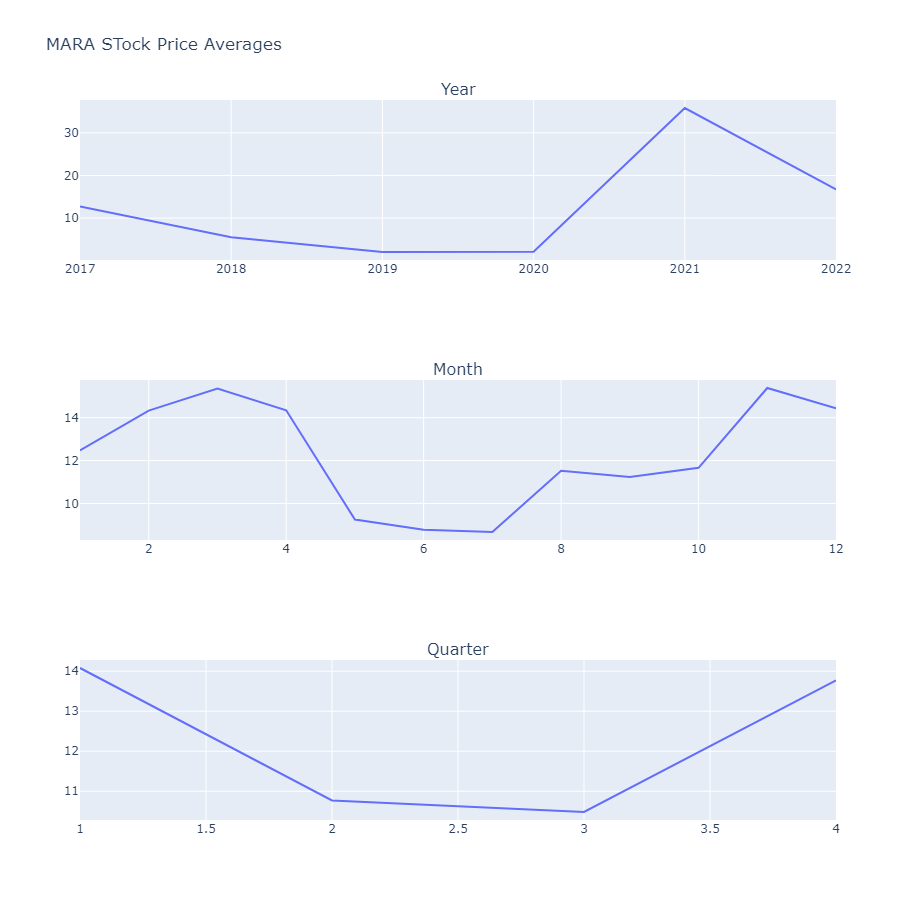

In [17]:
def period_prices(data=df, time_cols=['Month', 'Quarter','Year']):
    """ Visualize price averages by different time periods
    """
    #
    all_data = []
    
    for col in time_cols:
        avg_by_col = data.groupby(col).Price.mean()
        fig_data = px.line(avg_by_col)["data"]
        all_data.append(fig_data)

    fig = make_subplots(rows=len(all_data), cols=1,
                        subplot_titles=time_cols) 

    for i, figure in enumerate(all_data):
        for trace in range(len(figure)):
            fig.append_trace(figure[trace], row=i+1, col=1)

    fig.update_layout(title="MARA STock Price Averages", 
                      height=900, showlegend=False)
    fig.show()

period_prices()